Import all necessary libraries and install everything you need for training:

In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [2]:
# Install transformers
# (this needs to be done on Kaggle each time you start the session)
#!pip install -q transformers

In [3]:
# Install the simpletransformers
#!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

In [4]:
# Install wandb
#!pip install -q wandb

In [5]:
import wandb

In [6]:
# Login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /home/tajak/.netrc


True

In [7]:
# Clean the GPU cache

cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()


### Import the data

In [8]:
# FTD
train_df = pd.read_csv("data/FTD-train.txt", sep="\t", index_col=0)
dev_df = pd.read_csv("data/FTD-dev.txt", sep = "\t", index_col = 0)
test_df = pd.read_csv("data/FTD-test.txt", sep = "\t", index_col = 0)

print("FTD train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

FTD train shape: (849, 2), Dev shape: (283, 2), Test shape: (283, 2).


In [9]:
train_df.head()

,text,labels
1361,Business continuity plans must address massive...,7
1605,"( INDIANAPOLIS – APRIL 16 , 2010 ) – Ash conti...",8
733,Leek Friends of Israel welcome you to their we...,0
495,Npower announces further price increase Energy...,8
1534,"These businesses often had data , broad direct...",0


## Testing

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [10]:
# Create a file to save results into (you can find it under Data: Output). Be careful, run this step only once to not overwrite the results file.
#results = []

#with open("results/FTD-Experiments-Results.json", "w") as results_file:
#    json.dump(results,results_file, indent= "")

In [11]:
# Open the main results file:

previous_results_file = open("results/FTD-Experiments-Results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

4

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [13]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

[7, 8, 0, 1, 6, 5, 2, 4, 3, 9]

In [14]:
# Initialize Wandb
run = wandb.init(project="FTD-learning-manual-hyperparameter-search", entity="tajak", name="testing-trained-model")

wandb: Currently logged in as: tajak (use `wandb login --relogin` to force relogin)


In [15]:
# Load the trained model from Wandb
model_name = "FTD-classifier"
# Use the latest version of the model
model_at = run.use_artifact(model_name + ":latest")
# Download the directory
model_dir = model_at.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", model_dir)

wandb: Downloading large artifact FTD-classifier:latest, 1081.90MB. 8 files... Done. 0:0:0
/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [16]:
# See the model's arguments
arg_values = []
 
pd.set_option('display.max_rows', 100)
 
# For all of the arguments...
for arg in dir(model.args):
    
    # Skip over the special attributes and any functions.
    if (not arg[0:2] == '__') and (not callable(getattr(model.args, arg))):
    
        # Store the argument and its value as a tuple.
        arg_values.append((arg, str(getattr(model.args, arg))))
 
# Store as a dataframe just to get the pretty printout.
df_args = pd.DataFrame(arg_values)        
 
df_args


,0,1
0,adafactor_beta1,None
1,adafactor_clip_threshold,1.0
2,adafactor_decay_rate,-0.8
3,adafactor_eps,"[1e-30, 0.001]"
4,adafactor_relative_step,True
5,adafactor_scale_parameter,True
6,adafactor_warmup_init,True
7,adam_epsilon,1e-08
8,best_model_dir,outputs/best_model
9,cache_dir,cache_dir/


In [17]:
# Update the args
model = ClassificationModel(
    "xlmroberta", model_dir, args= {"silent":True})

/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [18]:
# Let's change the numeric values into nominal so that the confusion matrix is more informative
# here's the dictionary:
FTD_mapping = {0: 'A1 (argumentative)', 1: 'A11 (personal)', 2: 'A12 (promotion)', 3: 'A14 (academic)', 4: 'A16 (information)', 5: 'A17 (review)', 6: 'A4 (fiction)', 7: 'A7 (instruction)', 8: 'A8 (news)', 9: 'A9 (legal)'}

In [19]:
# Map the labels
LABELS_mapped = [FTD_mapping[x] for x in LABELS]
LABELS_mapped

['A7 (instruction)',
 'A8 (news)',
 'A1 (argumentative)',
 'A11 (personal)',
 'A4 (fiction)',
 'A17 (review)',
 'A12 (promotion)',
 'A16 (information)',
 'A14 (academic)',
 'A9 (legal)']

In [20]:
def testing_FTD(test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    """
    # Get the true labels
    y_true = test_df.labels

    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)
    test_df["y_pred"] = y_pred

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    y_true_mapped = y_true.map(FTD_mapping)
    test_df["y_true_mapped"] = y_true_mapped
    y_pred_mapped = y_pred.map(FTD_mapping)
    test_df["y_pred_mapped"] = y_pred_mapped
    # Plot the confusion matrix:
    cm = confusion_matrix(y_true_mapped, y_pred_mapped, labels=LABELS_mapped)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS_mapped
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"results/Confusion-matrix-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "experiment": test_name,
        "num_train_epochs": 10,
        "train_batch_size":8,
        "learning_rate": 1e-5,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true_mapped.to_dict(),
        "y_pred": y_pred_mapped.to_dict(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

    # Save the new dataframe which contains the y_pred values as well
    test_df.to_csv(f"results/{test_name}-sheet-with-predictions.csv", sep="\t")

In [21]:
testing_FTD(dev_df, "testing-FTD-model-on-dev")

print("\nTesting finished.")

KeyboardInterrupt: 

Macro f1: 0.74, Micro f1: 0.739


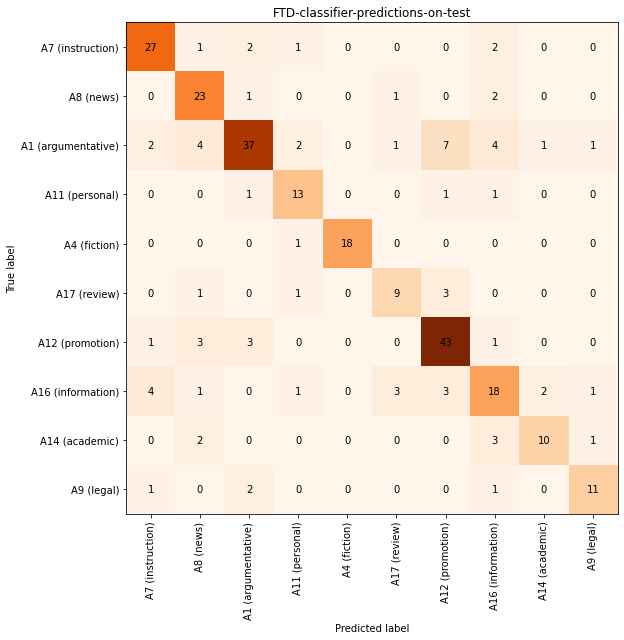


Testing finished.


<Figure size 432x288 with 0 Axes>

In [ ]:
testing(test_df, "FTD-classifier-predictions-on-test")
print("\nTesting finished.")

In [ ]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,testing-saved-FTD-model-on-dev,10,8,0.00001,0.749117,0.758662,"[2, 4, 0, 2, 4, 0, 3, 2, 7, 0, 2, 6, 9, 8, 4, ...","[0, 4, 0, 2, 3, 0, 3, 2, 7, 4, 2, 5, 9, 8, 4, ..."
1,testing-on-saved-FTD-classifier-test,10,8,0.00001,0.738516,0.739792,"[6, 2, 8, 7, 3, 2, 6, 8, 5, 8, 1, 7, 7, 2, 8, ...","[6, 7, 8, 7, 3, 0, 6, 8, 5, 8, 1, 7, 4, 2, 8, ..."
2,testing-FTD-model-on-dev,10,8,0.00001,0.749117,0.758662,"{875: 'A12 (promotion)', 1664: 'A16 (informati...","{875: 'A1 (argumentative)', 1664: 'A16 (inform..."
3,FTD-classifier-predictions-on-test,10,8,0.00001,0.738516,0.739792,"{926: 'A4 (fiction)', 673: 'A12 (promotion)', ...","{926: 'A4 (fiction)', 673: 'A7 (instruction)',..."


In [ ]:
# Save the file with updated results.
with open("results/FTD-Experiments-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

## Applying the FTD classifier to the GINCO dataset

In [ ]:
# Import data about GINCO
ginco_df = pd.read_csv("GINCO-and_MT-GINCO-mapped-GINCORE-FTD.csv.csv", sep="\t", index_col=0)
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,tertiary_level_1,tertiary_level_2,tertiary_level_3,split,domain,GINCORE,text,MT-text,text_length,FTD_pred
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news)
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,NaN,NaN,NaN,train,www.ss-sezana.si,Information/Explanation,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information)
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,Information/Explanation,Information/Explanation,Information/Explanation,train,www.kamnik-starejsi.si,Promotion,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion)
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,train,www.radiocelje.si,News,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158,A8 (news)
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,NaN,NaN,NaN,test,www.mtv.si,News,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,Promotion of a Product,Promotion of a Product,Promotion,train,khetanes.si,Information/Explanation,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86,A12 (promotion)
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,NaN,NaN,NaN,train,www.merkur.si,List of Summaries/Excerpts,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50,A12 (promotion)
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,NaN,NaN,NaN,train,www.sex2.si,List of Summaries/Excerpts,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295,A12 (promotion)
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,NaN,NaN,NaN,train,www.ipsos.si,Opinion/Argumentation,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409,A1 (argumentative)


In [ ]:
# Import data about GINCO
ginco_df = pd.read_csv("Data-Preparation/data/Sl-and-MT-GINCO-mapped-to-GINCORE-keeptext.csv")
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,tertiary_level_1,tertiary_level_2,tertiary_level_3,split,domain,GINCORE,full_text,MT-text,text_length
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,NaN,NaN,NaN,train,www.ss-sezana.si,Information/Explanation,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,Information/Explanation,Information/Explanation,Information/Explanation,train,www.kamnik-starejsi.si,Promotion,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,train,www.radiocelje.si,News,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,NaN,NaN,NaN,test,www.mtv.si,News,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,Promotion of a Product,Promotion of a Product,Promotion,train,khetanes.si,Information/Explanation,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,NaN,NaN,NaN,train,www.merkur.si,List of Summaries/Excerpts,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,NaN,NaN,NaN,train,www.sex2.si,List of Summaries/Excerpts,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,NaN,NaN,NaN,train,www.ipsos.si,Opinion/Argumentation,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409


In [ ]:
# First, use the Slovene data - rename the column with slovene text to "text"
ginco_df = ginco_df.rename(columns= {"full_text": "text"})
ginco_df.head(1)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,tertiary_level_1,tertiary_level_2,tertiary_level_3,split,domain,GINCORE,text,MT-text,text_length
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93


In [22]:
# Create a function to predict
def predict_FTD(df, new_file_name):
    """
    This function takes a dataset and applies the trained model on it to infer predictions.
	It returns and saves the resulting df with added columns with FTD predictions.

    Args:
    - df: dataframe on which we want to apply prediction. The text should be in a column "text".
    - new_file_name: define the name of the new file
    """
    # Predict on the df
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = df.text.apply(make_prediction)

    # Map the numeric categories, used for prediction, to nominal
    y_pred_mapped = y_pred.map(FTD_mapping)
    df["FTD_pred"] = y_pred_mapped

    # Save the new dataframe which contains the y_pred values as well
    df.to_csv(f"{new_file_name}", sep="\t")

    return df

In [ ]:
# Apply predictions
ginco_df = predict_FTD(ginco_df, "GINCO-and_MT-GINCO-mapped-GINCORE-FTD.csv")

In [ ]:
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,tertiary_level_1,tertiary_level_2,tertiary_level_3,split,domain,GINCORE,text,MT-text,text_length,FTD_pred
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news)
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,NaN,NaN,NaN,train,www.ss-sezana.si,Information/Explanation,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information)
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,Information/Explanation,Information/Explanation,Information/Explanation,train,www.kamnik-starejsi.si,Promotion,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion)
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,train,www.radiocelje.si,News,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158,A8 (news)
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,NaN,NaN,NaN,test,www.mtv.si,News,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,Promotion of a Product,Promotion of a Product,Promotion,train,khetanes.si,Information/Explanation,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86,A12 (promotion)
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,NaN,NaN,NaN,train,www.merkur.si,List of Summaries/Excerpts,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50,A12 (promotion)
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,NaN,NaN,NaN,train,www.sex2.si,List of Summaries/Excerpts,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295,A12 (promotion)
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,NaN,NaN,NaN,train,www.ipsos.si,Opinion/Argumentation,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409,A1 (argumentative)


In [ ]:
# Let's also apply the predictions to the MT GINCO set
ginco_df = ginco_df.rename(columns={"text":"Slovene_text", "FTD_pred":"FTD_pred_on_SL"})
ginco_df = ginco_df.rename(columns={"MT-text":"text"})

In [ ]:
ginco_df.head(1)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,tertiary_level_1,tertiary_level_2,tertiary_level_3,split,domain,GINCORE,Slovene_text,text,text_length,FTD_pred_on_SL
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news)


In [ ]:
ginco_df = predict_FTD(ginco_df, "GINCO-and_MT-GINCO-mapped-GINCORE-FTD-on-en-and-sl-text.csv")

In [ ]:
# Let's save the final version
ginco_df = ginco_df.rename(columns={"text":"MT_text", "FTD_pred":"FTD_pred_on_MT"})

ginco_df.to_csv("final_data/GINCO-MT-GINCO-keeptext-file-with-all-information.csv", sep="\t")

In [ ]:
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,tertiary_level_2,tertiary_level_3,split,domain,GINCORE,Slovene_text,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,NaN,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news)
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,NaN,NaN,train,www.ss-sezana.si,Information/Explanation,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information),A16 (information)
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,Information/Explanation,Information/Explanation,train,www.kamnik-starejsi.si,Promotion,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion),A12 (promotion)
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,NaN,NaN,train,www.radiocelje.si,News,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158,A8 (news),A8 (news)
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,NaN,NaN,test,www.mtv.si,News,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news),A8 (news)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,Promotion of a Product,Promotion,train,khetanes.si,Information/Explanation,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86,A12 (promotion),A8 (news)
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,NaN,NaN,train,www.merkur.si,List of Summaries/Excerpts,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50,A12 (promotion),A12 (promotion)
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,NaN,NaN,train,www.sex2.si,List of Summaries/Excerpts,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295,A12 (promotion),A12 (promotion)
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,NaN,NaN,train,www.ipsos.si,Opinion/Argumentation,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409,A1 (argumentative),A1 (argumentative)


In [ ]:
# Analyse in how many cases do the labels on SL and MT text differ
ginco_df["agreement"] = np.where((ginco_df["FTD_pred_on_SL"] != ginco_df["FTD_pred_on_MT"]), "no", "yes")

ginco_df.head(3)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,tertiary_level_3,split,domain,GINCORE,Slovene_text,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,agreement
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),yes
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,NaN,train,www.ss-sezana.si,Information/Explanation,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information),A16 (information),yes
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,Information/Explanation,train,www.kamnik-starejsi.si,Promotion,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion),A12 (promotion),yes


In [ ]:
ginco_df[ginco_df["agreement"] == "no"]

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,tertiary_level_3,split,domain,GINCORE,Slovene_text,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,agreement
11,8887,http://www.zadovoljna.si/forum?post_id=960155,2014,False,Forum,Forum,Forum,NaN,NaN,NaN,...,NaN,train,www.zadovoljna.si,Forum,Rozka30 glede Bele masajke se strinjam. Dobra ...,Rozka30 I agree about the White Masai. Good bo...,601,A17 (review),A11 (personal),no
13,9961,http://old.radiostudent.si/print.php?sid=30419...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,NaN,train,old.radiostudent.si,News,Lezbični in feministični klub v vsako vas Sobo...,A lesbian and feminist club in every village S...,956,A17 (review),A8 (news),no
20,7967,http://premisli.si/faq.html,2014,False,FAQ,Other,Other,NaN,NaN,NaN,...,NaN,test,premisli.si,FAQ,Naročila sprejemam na elektronsko naslov emobi...,Orders are accepted by e-mail to emobil@premis...,686,A12 (promotion),A7 (instruction),no
22,1247,http://zavod-emma.si/prijetno-druzenje-z-izmen...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,NaN,dev,zavod-emma.si,News,PRIJETNO DRUŽENJE Z IZMENJAVO RABLJENIH OBLAČI...,FRIENDLY FRIENDSHIP THROUGH EXCHANGE OF USED C...,190,A12 (promotion),A1 (argumentative),no
23,8760,http://www.viva.si/Zdrav-način-prehrane/2860/F...,2014,False,Instruction,Instruction,Instruction,Promotion of a Product,Promotion of a Product,Promotion,...,NaN,train,www.viva.si,Instruction,Fižol <p/> Povezano <p/> Superživilo <p/> V zg...,Beans <p/> Related <p/> Superfood <p/> Histori...,750,A16 (information),A7 (instruction),no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,19871313#3,https://bazar.coks.si/?cat=34&paged=9,2021,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,NaN,test,bazar.coks.si,News,Kaj ima skupnega vseh 500 najzmogljivejših sup...,What do the 500 most powerful supercomputers h...,394,A8 (news),A1 (argumentative),no
973,24071055,http://www.zvvs.si/?stran=novicedogodki&po=13/17,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,NaN,train,www.zvvs.si,List of Summaries/Excerpts,Domžalski veterani smo priredili že 24. spomin...,Domžale veterans organised the 24th commemorat...,319,A17 (review),A8 (news),no
987,33868957,http://splet.dc-dlan.si/teorija-spola/,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,Information/Explanation,Information/Explanation,Information/Explanation,...,NaN,train,splet.dc-dlan.si,Opinion/Argumentation,info@dc-dlan.si <p/> 0590 80 616 <p/> CONTACT ...,info@dc-dlan.si <p/> 0590 80 616 <p/> CONTACT ...,1879,A16 (information),A1 (argumentative),no
990,35970091,https://www.etno-muzej.si/sl/novice/sodelovanj...,2021,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,Promotion,train,www.etno-muzej.si,News,Slovenski etnografski muzej <p/> Sodelovanje S...,Slovenian Ethnographic Museum <p/> Cooperation...,51,A12 (promotion),A8 (news),no


Interestingly, only on 227 instances (around 1/5 of instances) are the FTD labels predicted to Slovene text different than those predicted on the MT text.

## Applying the FTD classifier to the CORE dataset

In [23]:
# Import data about CORE
core_df = pd.read_csv("Data-Preparation/data/CORE-all-information.csv", sep="\t", index_col=0)

core_df

,label,text,split,main_labels,sublabels,Len,main_len,sub_len,GINCORE,full_names,main_labels_full_names
0,NA OP SR OB,The Top TEN 'Whiniest Sets of Fans' in English...,train,NA OP,SR OB,4,2,2,NA OP SR OB,SR OB,NA OP
1,NA NE,"Ferry consultation needs deeper questions, say...",train,NaN,NE,2,1,1,News,News Report/Blog,Narrative
2,ID DF,I'v been recording and mixing music for about ...,train,ID,DF,2,1,1,Forum,Discussion Forum,Interactive Discussion
3,NA SR,The 25-year-old did have chances at Anfield. B...,train,NaN,SR,2,1,1,News,Sports Report,Narrative
4,NA IN HA,Elizabethan Science and Technology Elizabethan...,train,NA IN,HA,3,2,1,NA IN HA,Historical Article,NA IN
...,...,...,...,...,...,...,...,...,...,...,...
48444,NA NE,Lollapalooza heading to the Middle East in 201...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative
48445,OP AV,How to: Improve Brand Engagement on Twitter Ea...,dev,OP,AV,2,1,1,Opinion/Argumentation,Advice,Opinion
48446,OP OB,The Last Post. A shameful reflection on Canada...,dev,OP,OB,2,1,1,Opinion/Argumentation,Opinion Blog,Opinion
48447,NA NE,Related Stories Students at a Sherwood Park hi...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative


In [24]:
core_df = predict_FTD(core_df, "final_data/CORE-all-information-FTD-predicted.csv")